# Practica 5 (Regresión lineal regularizada: sesgo y varianza)
### Aprendizaje automático y big data
##### _Alberto García Doménech - Pablo Daurell Marina_    
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

El objetivo de esta práctica es comprobar los efectos del sesgo (bias) y la varianza. Para ello entrenaremos a un modelo de regresión lineal regularizada.   

Usaremos un dataset que representa datos históricos del agua que ha derramado una presa en base a los cambios del nivel del agua.

In [2]:
# Cargamos los datos
data = loadmat('ex5data1.mat')

# Datos de entrenamiento
X = data['X']
y = data['y']
# Datos de test
Xtest = data['Xtest']
ytest = data['ytest']
# Datos de validacion cruzada
Xval = data['Xval']
yval = data['yval']

X = np.hstack([np.ones([np.shape(X)[0], 1]), X])
Xtest = np.hstack([np.ones([np.shape(Xtest)[0], 1]), Xtest])
Xval = np.hstack([np.ones([np.shape(Xval)[0], 1]), Xval])

## Regresión lineal regularizada

Vamos a implementar las funciones para calcular el coste y el gradiente regularizados de nuestro modelo de regresión lineal:

In [3]:
def cost(Theta, X, Y, reg):
    H = np.dot(X, Theta)
    aux = np.sum((H - Y.ravel())**2)
    regul = reg * np.sum(Theta[1:]**2)
    cost = (aux + regul) / (2*len(X))
    return cost

def gradient(Theta, X, Y, reg):
    H = np.dot(X, Theta)
    grad = np.dot(X.T, H - Y.ravel()) / len(X)
    regul = (reg/len(X)) * Theta[1:]
    grad[1:] += regul
    return grad

In [4]:
reg = 1
theta = np.ones(np.shape(X)[1])
print("Coste: ", cost(theta, X, y, reg))
print("Gradiente: ", gradient(theta, X, y, reg))

Coste:  303.9931922202643
Gradiente:  [-15.30301567 598.25074417]



Hacemos uso de la funcion de scipy, ```minimize```, para encontrar un valor de Theta que minimize el coste: 

In [5]:
import scipy.optimize as opt

theta = np.zeros(np.shape(X)[1])
reg = 0

fmin = opt.minimize(fun=cost, x0=theta, args=(X, y, reg))
theta_opt = fmin.x

print("Theta optima: ", theta_opt, ", Coste: ", cost(theta_opt, X, y, reg))

Theta optima:  [13.08790357  0.36777923] , Coste:  22.373906495108923


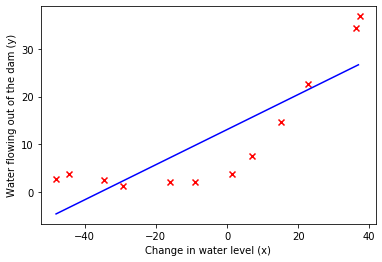

In [6]:
plt.scatter(X[:, 1:], y, color='red', marker='x')
x_arr = np.arange(min(X.ravel()), max(X.ravel()))
y_arr = []
for x in x_arr:
    x = list(x.ravel())
    x.insert(0, 1)
    y_arr.append(np.dot(x, theta_opt))
    
plt.plot(x_arr, y_arr, color='blue')    
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.show()

> Vemos que la predicción resultante de entrenar a nuestro modelo es muy poco precisa ya que tenemos pocos datos y además, tal y como están distribuidos, una recta es demasiado simple para ajustarse bien.

## Curvas de aprendizaje

Vamos a pintar las curvas de aprendizaje resultantes de entrenar al modelo con distintos subconjuntos de los ejemplos de entrenamiento, para ver como varía el coste.
Una vez entrenado también vamos a comprobar la variación del coste en el conjunto de datos de validación cruzada.

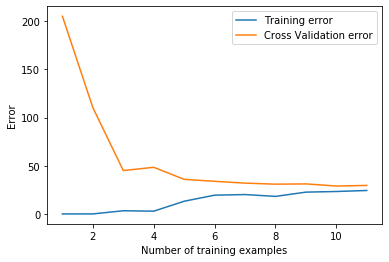

In [10]:
training_x = []
training_y = []
crossval_x = []
crossval_y = []

theta = np.zeros((X.shape[1], 1))
reg = 0

for i in range(1, X.shape[0]):
    training_x.append(i)
    crossval_x.append(i)
    theta_opt = opt.minimize(fun=cost, args=(X[0:i], y[0:i], reg), x0=theta).x
    training_y.append(cost(theta_opt, X[0:i], y[0:i], 0))
    crossval_y.append(cost(theta_opt, Xval, yval, 0))

plt.plot(training_x, training_y, label='Training error')
plt.plot(crossval_x, crossval_y, label='Cross Validation error')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend()
plt.show()

> Vemos que a medida que aumentan el numero de ejemplos de entrenamiento, el error del conjunto de entrenamiento y el de validación cruzada se aproximan. Esto indica que se está produciendo un aprendizaje sesgado.

## Regresión polinomial

Para corregir el sesgo de nuestro modelo vamos a crear un polinimio a partir de los datos de entrada para aumentar la cantidad de atributos de los ejemplos: